**Identificación de *outliers* en Series de Tiempo**

Un paso fundamental en el análisis de datos es la identificación de *outliers* en las observaciones. Estos son aquellos puntos que se desvían significativamente del resto de los datos; comunmente son causados por errores de ingreso, aunque no deben descartarse otras causas. <br>
Los *outliers* pueden tener un impacto negativo en el análisis de series de tiempo, ya que alteran estadígrafos como el promedio o la desviación estándar.<br>
Por lo tanto; pueden inducir conclusiones equivocadas.<br>
Este notebook es un resumen basado en el artículo publicado en https://mlpills.dev/time-series/clean-your-time-series-data-iii/<br>
Lectura que se recomienda ya que profundiza en el tema y ejemplifica otros métodos.

**Técnicas de identificación de *outliers* en *Python***

Inspección visual: Este es siempre el primer paso en la metodología EDA (*Exploratory Data Analysis*). Rara vez nos permitirá **identificar** los *outliers*, pero sí podremos confirmar su existencia, al tratarse de un método efectivo e intuitivo.<br>
Box-plot: Este se mantiene como mi favorito, siendo una técnica robusta que los identifica claramente.<br>
En el ejemplo que sigue, los datos han sido agregados por mes.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
dfBeer = pd.read_csv("./beer.csv")

In [3]:
dfBeer.head(1)

,month,production
0,1956-01,93.2


In [4]:
dfBeer.dtypes

month          object
production    float64
dtype: object

En las series de tiempo, el índice del *dataframe* debe ser la fecha.<br>
La columna `month`, no es de tipo fecha, por lo que hay que convertirla. 

In [5]:
dfBeer['month'] = pd.to_datetime(dfBeer['month'], format='%Y-%m')

In [6]:
dfBeer.dtypes

month         datetime64[ns]
production           float64
dtype: object

In [7]:
#Ahora dejamos la columna month como índice del dataframe
dfBeer = dfBeer.set_index('month')

El análsis debe hacerse sobre un conjunto de datos con distribución normal, 

In [8]:
#Si bien hay otros métodos, usaremos diferenciación
dfBeer = dfBeer.diff()
#También se deben borrar los primeros NaN, que provienen de la diferenciación
dfBeer = dfBeer.dropna()

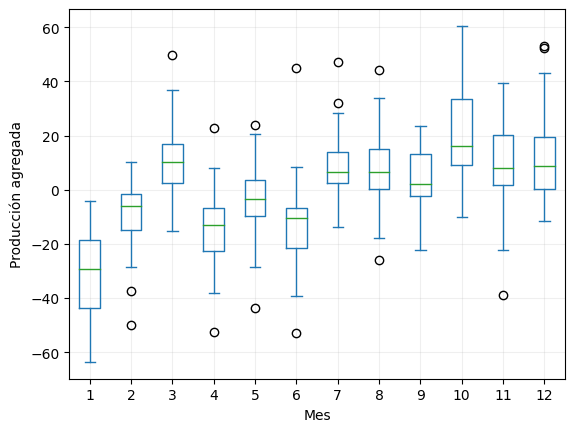

In [9]:
 # Agregación por mes
dfBeer.set_index(dfBeer.index.month, append=True).production.unstack().plot.box()
plt.xlabel('Mes')
plt.ylabel('Producción agregada')
plt.grid(which='both', alpha=0.2)
plt.show()

En el gráfico anterior se **observan** varios *outliers*. A través del método IQR (*Interquartile range*), los **identificaremos**

**El método IQR**

Es un método estadístico útil para identificar *outliers*. El factor IQR es la diferencia entre el primer cuartil (Q1) y el tercer cuartil (Q3), lo cual representa el 50% de los datos (el rectángulo en el gráfico).
<center>IQR = Q3 - Q1 </center><br>
Luego multiplicamos el IQR por un factor constante, típicamente 1.5, y determinamos el límite superior e inferior del rango dentro del cual los valores se aceptan como válidos. Por lo tanto:<br>
Límite inferior = Q1 - 1.5 * IQR<br>
Límite superior = Q3 + 1.5 * IQR<br>
Cualquier punto fuera de esos límites, se considera un posible outlier.<br>

In [31]:
# Eliminación de Outliers
 
listaOutliers = []

for month in range(13):

    # Agrego valores mensuales
    dfMonth = dfBeer[dfBeer.index.month == month]
    
    # Calculo Q1, Q3 e IQR
    q1 = dfMonth.production.quantile(0.25)
    q3 = dfMonth.production.quantile(0.75)
    iqr = q3 - q1
    
    # Detección de anomalías
    abnormal_dates = dfMonth[(dfMonth.production < q1 - 1.5 * iqr) \
                         | (dfMonth.production > q3 + 1.5 * iqr)].index
    
    # Agrego las anomalías a la lista
    if not abnormal_dates.empty:
      listaOutliers = listaOutliers + list(abnormal_dates)

**Eliminación**
Una vez identificados los *outliers*, se pueden remover del dataframe. Sin embargo; el registro puede contener otra información importante, por lo que en lugar de eliminarlos físicamente, se les asignará un valor nulo: `NaN` (no es cero)

In [32]:
# Dejo los outliers como NaN
dfBeer.loc[listaOutliers, 'production'] = np.nan

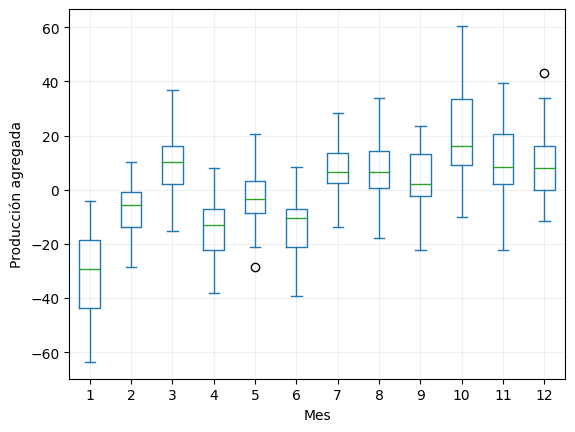

In [27]:
# Compruebo resultados
dfBeer.set_index(dfBeer.index.month, append=True).production.unstack().plot.box()
plt.xlabel('Mes')
plt.ylabel('Producción agregada')
plt.grid(which='both', alpha=0.2)
plt.show()

En el gráfico anterior se observa que se mantienen dos *outliers*, esto es porque la eliminación de los anteriores modificó la distribución, esto demuestra que siempre es conveniente comprobar los resultados, y como en este ejemplo se debe ejecutar nuevamente la rutina de identificación.

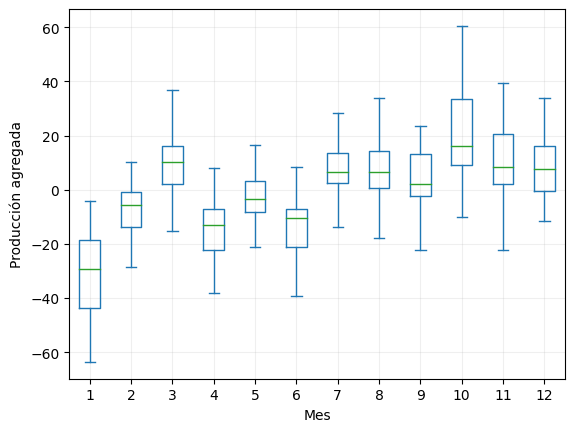

In [33]:
# Compruebo resultados
dfBeer.set_index(dfBeer.index.month, append=True).production.unstack().plot.box()
plt.xlabel('Mes')
plt.ylabel('Producción agregada')
plt.grid(which='both', alpha=0.2)
plt.show()

In [34]:
#Calculo cuántos oultiers se determinaron finalmente.
dfBeer.isna().sum()

production    19
dtype: int64